# Evidence estimation in a Bayesian cognitive model


In [1]:
%load_ext autoreload
%autoreload 2

import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = '4'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [4]


In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import jax
jax.config.update("jax_enable_x64", True)  # Do we need this here? -> it seems we do for the LML computations (otherwise NaNs get introduced), but not for performance

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
import pandas as pd
import jax.scipy.special as jsp

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import pyreadr as pr

from distrax._src.distributions.distribution import Distribution

import os
import sys
import requests

from blackjax import normal_random_walk

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

import bamojax
from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, smc_inference_loop, mcmc_sampler

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('BaMoJax version:      ', bamojax.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

SMALL_SIZE = 14
MEDIUM_SIZE = 16
LARGE_SIZE = 22

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
BaMoJax version:       0.0.1
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


In [3]:
def download_to_disk(url, filepath):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filepath, 'wb') as file:
            file.write(response.content)
        print('File downloaded successfully!')
    else:
        print(f'Failed to download the file. Status code: {response.status_code}')

#
data_busemeyer_url = 'https://osf.io/download/5vws6/'  # DataBusemeyerNoNA.rdata on https://osf.io/f9cq4/; contains IGT data
data_busemeyer_file = 'DataBusemeyerNoNA.rdata'

data_steingroever_url = 'https://osf.io/download/bmnsv/'  # contains Steingroever's importance sampling marginal likelihoods
data_steingroever_file = 'DataSteingroever.rdata'

lml_url = 'https://osf.io/download/txnbs/' # ind_LogMargLik.txt on https://osf.io/f9cq4/; contains Gronau's bridge sampling estmates
lml_file = 'ind_LogMargLik.txt'

download_to_disk(data_busemeyer_url, data_busemeyer_file)
download_to_disk(data_steingroever_url, data_steingroever_file)
download_to_disk(lml_url, lml_file)

File downloaded successfully!
File downloaded successfully!
File downloaded successfully!


In [4]:
data_file = pr.read_r('DataBusemeyerNoNA.rdata')
choices = jnp.asarray(data_file['choice'].to_numpy().astype(int)) - 1  # Python zero-indexing
losses = jnp.asarray(data_file['lo'].to_numpy())
wins = jnp.asarray(data_file['wi'].to_numpy())

N, T = choices.shape
K = 4

print(wins.shape)
print(losses.shape)
print(choices.shape)

(30, 100)
(30, 100)
(30, 100)


Discrepancy with LML

We are not matching this correctly. Note that the paper probably starts at $t=1$

In [5]:
def ev_link_fn(w, a, c_raw, choices, wins, losses):
    c = 4*c_raw - 2.0
    ev = jnp.zeros((K, ))
    logits = jnp.ones((T, K))  # softmax of uniform is = [1/K, 1/K, ...]

    def for_body(t, carry):
        ev_, logits_ = carry
        theta = (0.1*(t+1))**c  
        current_utility = (1-w) * wins[t] + w*losses[t]
        k = choices[t]
        ev_ = ev_.at[k].add(a * (current_utility - ev_[k]))
        logits_ = logits_.at[t + 1, :].set(theta * ev_)
        return (ev_, logits_)
    
    #
    _, logits = jax.lax.fori_loop(0, T - 1, for_body, (ev, logits))

    return dict(logits=logits)

#
def make_ev_model(subject):
    EVModel = Model(f'Expectance valence model, subject {subject}')
    w_node = EVModel.add_node('w', distribution=dx.Beta(alpha=1.0, beta=1.0))
    a_node = EVModel.add_node('a', distribution=dx.Beta(alpha=1.0, beta=1.0))
    c_raw_node = EVModel.add_node('c_raw', distribution=dx.Beta(alpha=1.0, beta=1.0))
    wins_node = EVModel.add_node('wins', observations=wins[subject, :])
    loss_node = EVModel.add_node('losses', observations=losses[subject, :])

    # Note that in RL examples we often have a form of autoregression. Here, `choices` are observed, but also feed back into the model.
    choice_node = EVModel.add_node('choices', 
                                observations=choices[subject, :], 
                                distribution=dx.Categorical, 
                                link_fn=ev_link_fn, 
                                parents=dict(w=w_node, 
                                                a=a_node, 
                                                c_raw=c_raw_node, 
                                                choices=choices[subject,:], 
                                                wins=wins_node, 
                                                losses=loss_node))
    return EVModel

#

In [ ]:
%%time
def wrapper(key, subject):
    evmodel = make_ev_model(subject=subject)
    mcmc_params = dict(sigma=stepsize*jnp.eye(evmodel.get_model_size()))
    mcmc = mcmc_sampler(evmodel, mcmc_kernel=normal_random_walk, mcmc_parameters=mcmc_params)
    _, lml, _, _ = smc_inference_loop(key, model=evmodel, kernel=mcmc, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps, num_chains=num_chains)
    return lml

#
num_chains = 1
num_mcmc_steps = 100
num_particles = 1000
stepsize = 0.01

subjects = jnp.arange(N)
key = jrnd.PRNGKey(42)
keys = jrnd.split(key, N)
lml_scores = jax.vmap(wrapper)(keys, subjects)
print(lml_scores)

[-130.05606422 -104.304702   -115.01661459 -117.6102349  -104.62734226
 -136.5219389  -137.80943144 -129.57020252 -141.53107173  -89.60655731
 -133.20964921 -140.63396312 -140.39241233 -133.01253722 -132.98674801
 -136.9590195  -135.94740832 -110.14573532 -106.32182309 -141.43004044
 -140.86481362 -109.79922414 -118.83133881 -138.42908037 -131.53498574
 -122.10016868 -125.43281934 -140.85642584 -137.79392749 -128.57361509]
CPU times: user 40.8 s, sys: 16.9 s, total: 57.7 s
Wall time: 53.7 s


Correlation between SMC and Importance sampling is 1.000
Correlation between SMC and Bridge sampling is 1.000


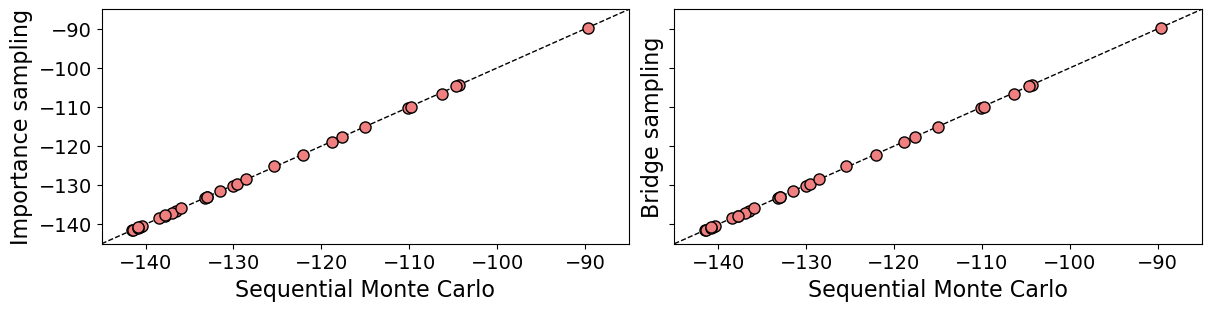

In [7]:
from pathlib import Path

lims = [-145, -85]
bs_lmls_file = open(f'ind_LogMargLik.txt')
lines = bs_lmls_file.readlines()
bs_lmls = jnp.array([float(line.split()[1]) for line in lines[1:]])

is_lmls_file = pr.read_r(os.path.join(Path(os.getcwd()).parents[0], 'cognitive_models/DataSteingroever.rdata'))
is_lmls = jnp.squeeze(jnp.log(pr.read_r(f'/scratch/big/home/maxhin/Documents/Code/SMC tutorial/EV/data/margLike_SteingroeverEtAl2016_importance_sampling.Rdata')['marg.like'].to_numpy()))

baselines = [is_lmls, bs_lmls]

baseline_names = ['Importance sampling', 'Bridge sampling']

_, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, constrained_layout=True, figsize=(12, 3))
for i, (baseline, name, ax) in enumerate(zip(baselines, baseline_names, axes)):
    print(f'Correlation between SMC and {name} is {jnp.corrcoef(lml_scores, baseline)[0, 1]:0.3f}')
    ax.scatter(lml_scores, baseline, c='lightcoral', edgecolors='k', s=64, zorder=10)
    ax.plot(lims, lims, ls='--', c='k', lw=1, zorder=5)
    ax.set_xlabel('Sequential Monte Carlo')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_ylabel(name)

## The hierarchical expectance valence model

In [5]:
def hev_link_fn(w_unlinked, a_unlinked, c_unlinked, choices, wins, losses):
    w = tfb.NormalCDF().forward(w_unlinked)
    a = tfb.NormalCDF().forward(a_unlinked)
    c = 4*tfb.NormalCDF().forward(c_unlinked) - 2.0
    ev = jnp.zeros((N, K))
    logits = jnp.ones((N, T, K))  # softmax of uniform is = [1/K, 1/K, ...]
    row_inds = jnp.arange(N)

    def for_body(t, carry):
        ev_, logits_ = carry
        theta = (0.1*(t+1))**c  
        current_utility = (1-w) * wins[:, t] + w*losses[:, t]
        k = choices[:, t]
        ev_ = ev_.at[row_inds, k].add(a * (current_utility - ev_.at[row_inds, k].get()))
        logits_ = logits_.at[row_inds, t + 1, :].set(theta[:, jnp.newaxis] * ev_)
        return (ev_, logits_)
    
    #
    _, logits = jax.lax.fori_loop(0, T - 1, for_body, (ev, logits))

    return dict(logits=logits)

#


HEVModel = Model(f'Hierarchical expectance valence model')
mu_w_node = HEVModel.add_node('mu_w', dx.Normal(loc=0.0, scale=1.0))
mu_a_node = HEVModel.add_node('mu_a', dx.Normal(loc=0.0, scale=1.0))
mu_c_node = HEVModel.add_node('mu_c', dx.Normal(loc=0.0, scale=1.0))

sigma_w_node = HEVModel.add_node('sigma_w', dx.Uniform(low=0.0, high=1.5))
sigma_a_node = HEVModel.add_node('sigma_a', dx.Uniform(low=0.0, high=1.5))
sigma_c_node = HEVModel.add_node('sigma_c', dx.Uniform(low=0.0, high=1.5))

w_node = HEVModel.add_node('w_unlinked', distribution=dx.Normal, parents=dict(loc=mu_w_node, scale=sigma_w_node), shape=(N, ))
a_node = HEVModel.add_node('a_unlinked', distribution=dx.Normal, parents=dict(loc=mu_a_node, scale=sigma_a_node), shape=(N, ))
c_node = HEVModel.add_node('c_unlinked', distribution=dx.Normal, parents=dict(loc=mu_c_node, scale=sigma_c_node), shape=(N, ))

wins_node = HEVModel.add_node('wins', observations=wins)
loss_node = HEVModel.add_node('losses', observations=losses)

# # Note that in RL examples we often have a form of autoregression. Here, `choices` are observed, but also feed back into the model.
choice_node = HEVModel.add_node('choices', 
                                observations=choices, 
                                distribution=dx.Categorical, 
                                link_fn=hev_link_fn, 
                                parents=dict(w_unlinked=w_node, 
                                             a_unlinked=a_node, 
                                             c_unlinked=c_node, 
                                             choices=choices,
                                             wins=wins_node, 
                                             losses=loss_node))

HEVModel.print_gibbs()

Gibbs structure:
mu_w                : p(w_unlinked | sigma_w, mu_w) p(mu_w)
sigma_w             : p(w_unlinked | sigma_w, mu_w) p(sigma_w)
w_unlinked          : p(choices | c_unlinked, choices_choices, losses, w_unlinked, a_unlinked, wins) p(w_unlinked | sigma_w, mu_w)
mu_a                : p(a_unlinked | mu_a, sigma_a) p(mu_a)
sigma_a             : p(a_unlinked | mu_a, sigma_a) p(sigma_a)
a_unlinked          : p(choices | c_unlinked, choices_choices, losses, w_unlinked, a_unlinked, wins) p(a_unlinked | mu_a, sigma_a)
mu_c                : p(c_unlinked | mu_c, sigma_c) p(mu_c)
sigma_c             : p(c_unlinked | mu_c, sigma_c) p(sigma_c)
c_unlinked          : p(choices | c_unlinked, choices_choices, losses, w_unlinked, a_unlinked, wins) p(c_unlinked | mu_c, sigma_c)


In [ ]:
%%time
key = jrnd.PRNGKey(42)
num_chains = 1
num_mcmc_steps = 5
num_particles = 1000
stepsize = 0.02

mcmc_params = dict(sigma=stepsize*jnp.eye(HEVModel.get_model_size()))
mcmc = mcmc_sampler(HEVModel, mcmc_kernel=normal_random_walk, mcmc_parameters=mcmc_params)
final_state, lml, num_adapt, final_info = smc_inference_loop(key, model=HEVModel, kernel=mcmc, num_particles=num_particles, num_mcmc_steps=num_mcmc_steps, num_chains=num_chains)

print(final_info.update_info)
print(lml)

Is the LML estimate better/quicker with Gibbs? 

In [ ]:
key = jrnd.PRNGKey(1234)

num_chains = 1
num_mcmc_steps = 100
num_particles = 1000

step_fns = dict(mu_w=normal_random_walk, 
                mu_a=normal_random_walk, 
                mu_c=normal_random_walk, 
                w_unlinked=normal_random_walk, 
                a_unlinked=normal_random_walk, 
                c_unlinked=normal_random_walk,
                sigma_w=normal_random_walk,
                sigma_a=normal_random_walk,
                sigma_c=normal_random_walk)
step_fn_params = dict(mu_w=dict(sigma=0.3), 
                      mu_a=dict(sigma=0.3), 
                      mu_c=dict(sigma=0.3), 
                      w_unlinked=dict(sigma=0.01), 
                      a_unlinked=dict(sigma=0.05), 
                      c_unlinked=dict(sigma=0.01),
                      sigma_w=dict(sigma=0.1),
                      sigma_a=dict(sigma=0.1),
                      sigma_c=dict(sigma=0.1))

gibbs = gibbs_sampler(HEVModel, step_fns=step_fns, step_fn_params=step_fn_params)

final_state, lml, num_adapt, final_info = smc_inference_loop(key, 
                                                             model=HEVModel, 
                                                             kernel=gibbs, 
                                                             num_particles=num_particles, 
                                                             num_mcmc_steps=num_mcmc_steps, 
                                                             num_chains=num_chains)

print('Log marginal likelihood:', lml)
for var in step_fns.keys():
    print(f'Acceptance rate {var}: {jnp.mean(final_info.update_info[var].is_accepted)}')

Log marginal likelihood: -3803.9558479157995
Acceptance rate mu_w: 0.7903199791908264
Acceptance rate mu_a: 0.8460399508476257
Acceptance rate mu_c: 0.7960699796676636
Acceptance rate w_unlinked: 0.011529999785125256
Acceptance rate a_unlinked: 0.12410999834537506
Acceptance rate c_unlinked: 0.050370000302791595
Acceptance rate sigma_w: 0.9640799760818481
Acceptance rate sigma_a: 0.9758299589157104
Acceptance rate sigma_c: 0.9666799902915955


This is very slow, but the LML estimate is near that of 5K MCMC steps for RMW (-3803.96).

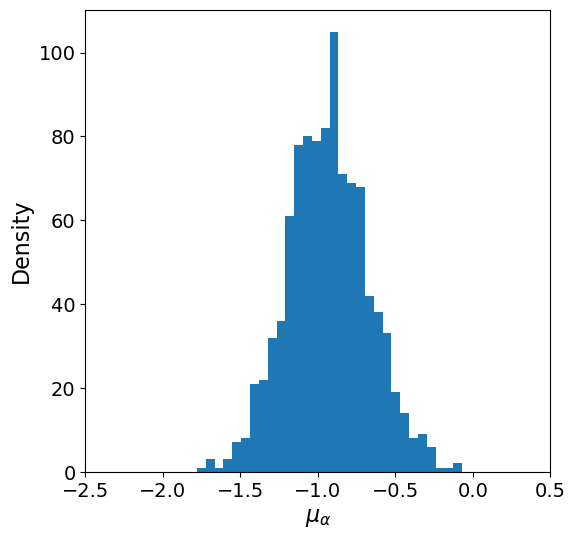

In [25]:
plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.hist(final_state.particles['mu_a'], bins=30)
ax.set_xlim([-2.5, 0.5])
ax.set_xlabel(r'$\mu_\alpha$')
ax.set_ylabel('Density');